# Exploratory data analysis

## 1. Dataset description

1) Global COVID-19 datasets

- The two COVID-19 datasets, [the global confirmed dataset](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv) and [the global death dataset](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv), are from the [data repository](https://github.com/CSSEGISandData/COVID-19) for the 2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE). The dataset is updated everyday starting from January 22nd, 2020.

- Both datasets contain columns of location information (`Province/State`, `Country/Region`, `Lat`, and `Long`) or daily accumulated number of confirmed or deaths in the corresponding location, starting from `1/22/20` to present.

- As stated in the dataset repository, "Australia, Canada and China are reported at the province/state level. Dependencies of the Netherlands, the UK, France and Denmark are listed under the province/state level. The US and other countries are at the country level."

- The datasets combine data from multiple sources and may contain mistakes.



## 2. Load the dataset

In [1]:
library(MASS)
library(mice)
library(resample)

library(testthat)
library(rjson)

library(plotly)
library(htmlwidgets)
library(repr)
library(cowplot)
library(tidyverse)


Warning message:
"package 'mice' was built under R version 3.6.2"
Loading required package: lattice


Attaching package: 'mice'


The following objects are masked from 'package:base':

    cbind, rbind


Warning message:
"package 'testthat' was built under R version 3.6.2"
Loading required package: ggplot2


Attaching package: 'plotly'


The following object is masked from 'package:ggplot2':

    last_plot


The following object is masked from 'package:MASS':

    select


The following object is masked from 'package:stats':

    filter


The following object is masked from 'package:graphics':

    layout



********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Registered S3 method overwritten by 'modelr':
  method         from    
  print.resample resample

-- 

In [2]:
# get the most recent global COVID-19 confirmed and deaths datasets
url <- "https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series"
covid19_confirmed <- read_csv(paste(url, "/time_series_covid19_confirmed_global.csv?raw=true", sep = ""))
covid19_death <- read_csv(paste(url, "/time_series_covid19_deaths_global.csv?raw=true", sep = ""))

Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)

See spec(...) for full column specifications.



In [3]:
head(covid19_confirmed)

Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469
NA,Albania,41.1533,20.1683,0,0,0,0,0,0,...,663,678,712,726,736,750,766,773,782,789
NA,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295
NA,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,723,731,738,738,743,743,743,745,745,747
NA,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,25,25,25,26,27,27,27,27,30,35
NA,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,...,24,24,24,24,24,24,24,24,25,25


## 3. Explore the dataset

In [6]:
print("Check the dimension of the global confirmed dataset:")
dim(covid19_confirmed)
print(paste("The most recent data in the global confirmed dataset is from", 
      colnames(covid19_confirmed)[length(covid19_confirmed)]))

print("Check the dimension of the global deaths dataset:")
dim(covid19_death)
print(paste("The most recent data in the global deaths dataset is from", 
            colnames(covid19_death)[length(covid19_death)]))

print(paste("There are", length(unique(covid19_confirmed[`Country/Region`])), 
            "unqiue countries in the global COVID-19 datasets"))


[1] 266 105

[1] "5/1/20"

[1] 266 105

[1] "5/1/20"

[1] 151

In [7]:
test_that("Column names of covid19_confirmed and covid19_death should be the same.",
          {expect_true(all(colnames(covid19_confirmed) == colnames(covid19_death)))
          })

test_that("The country column of covid19_confirmed and covid19_death should be the same.",
          {expect_true(all(covid19_confirmed[2] == covid19_death[2]))
          })

test_that("The last column of covid19_confirmed should not have missing values.",
          {expect_true(all(!is.na(covid19_confirmed[length(covid19_confirmed)])))
          })

test_that("The last column of covid19_death should not have missing values.",
          {expect_true(all(!is.na(covid19_death[length(covid19_death)])))
          })

## 4. Initial thoughts


## 5. Wrangling

In [14]:
#' Extracts COVID-19 confirmed and death numbers
#' of a given country from the global datasets
#'
#' @param country the country name
#'
#' @return dataframe
get_country_data <- function(country) {
    df <- covid19_confirmed %>%
        filter(`Country/Region` == country) %>%
        select(-`Country/Region`, -Lat, -Long, -`Province/State`) %>%
        gather("date", "confirmed") %>%
        mutate(date = lubridate::mdy(date)) %>%
        group_by(date) %>%
        summarize(confirmed = sum(confirmed))

    death <- covid19_death %>%
        filter(`Country/Region` == country) %>%
        select(-`Country/Region`, -Lat, -Long, -`Province/State`) %>%
        gather("date", "death") %>%
        mutate(date = lubridate::mdy(date)) %>%
        group_by(date) %>%
        summarize(death = sum(death))
    
    df$death <- death$death
    df
}

In [17]:
us_data <- get_country_data("US")
canada_data <- get_country_data("Canada")

In [18]:
summary(us_data)
summary(canada_data)

      date              confirmed           death      
 Min.   :2020-01-22   Min.   :      1   Min.   :    0  
 1st Qu.:2020-02-16   1st Qu.:     13   1st Qu.:    0  
 Median :2020-03-12   Median :   1921   Median :   45  
 Mean   :2020-03-12   Mean   : 223943   Mean   :11492  
 3rd Qu.:2020-04-06   3rd Qu.: 389420   3rd Qu.:15617  
 Max.   :2020-05-02   Max.   :1132539   Max.   :66369  

      date              confirmed            death       
 Min.   :2020-01-22   Min.   :    0.00   Min.   :   0.0  
 1st Qu.:2020-02-16   1st Qu.:    7.25   1st Qu.:   0.0  
 Median :2020-03-12   Median :  155.00   Median :   1.0  
 Mean   :2020-03-12   Mean   :10749.20   Mean   : 474.6  
 3rd Qu.:2020-04-06   3rd Qu.:17544.75   3rd Qu.: 366.0  
 Max.   :2020-05-02   Max.   :57926.00   Max.   :3684.0  

In [35]:
us_data$country = 'US'
canada_data$country = 'Canada'
cb_data <- cbind(us_data, canada_data)

## 6. Research questions



## 7. Data Analysis & Visualizations

In [41]:
t <- theme(plot.title = element_text(size = 20),
           axis.title = element_text(size = 18),
           text = element_text(size = 16),
           legend.title = element_text(size = 18),
           legend.text = element_text(size = 18),
           strip.text.x = element_text(size = 18))
options(repr.plot.width = 10, repr.plot.height = 7)

#' Plots time series of COVID-19 confirmed and 
#' death numbers
#'
#' @param df the dataframe to plot
#' @param name the country name
#'
#' @return ggplot plot
plot_ts <-  function (df, name){
    
    df %>%
        gather("term", "number", - date, - country) %>%
        ggplot(aes(date, number, color = term)) +
        geom_line() +
        scale_x_date(date_labels = "%Y %b %d")  +
        theme_bw() +
        labs(title = paste("The COVID-19 confirmed and death numbers in", name),
             color = "Line") + t
    
}

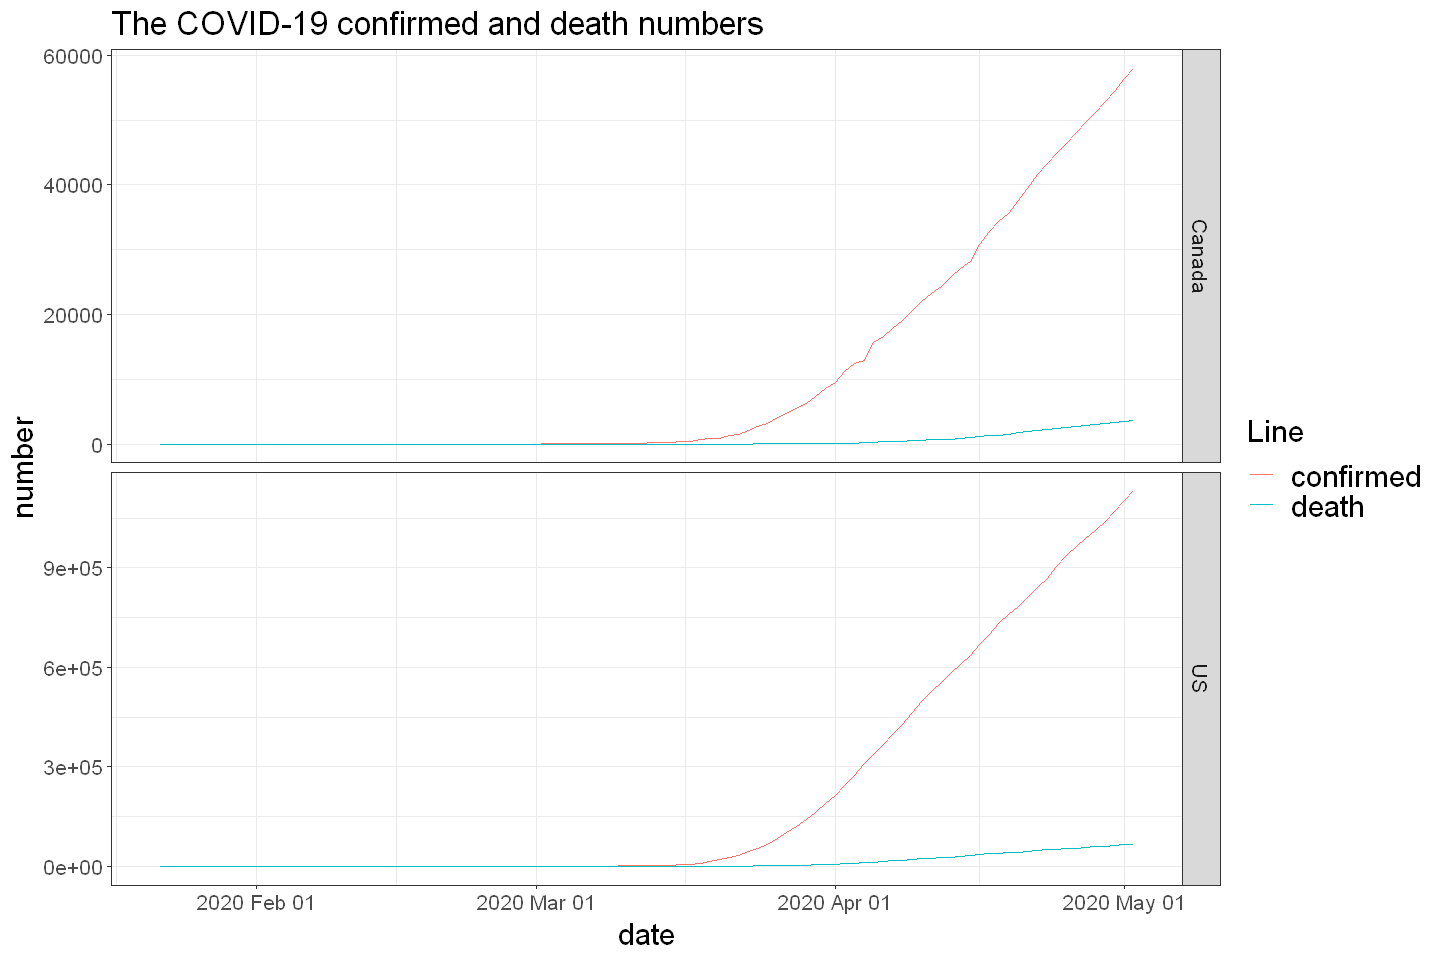

In [50]:
options(repr.plot.width = 12, repr.plot.height = 8)
cb_data %>%
    gather("term", "number", - date, - country) %>%
    ggplot(aes(date, number, color = term)) +
    geom_line() +
    scale_x_date(date_labels = "%Y %b %d") +
    facet_grid(rows = vars(country), scales = "free") +
    theme_bw() +
    labs(title = "The COVID-19 confirmed and death numbers",
         color = "Line") + t

## 8. Summary and conclusions
